https://datascience.stackexchange.com/questions/107580/is-there-a-way-to-output-feature-importance-based-on-the-outputted-class

https://christophm.github.io/interpretable-ml-book/

In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.cuda.set_device(1)
torch.cuda.current_device()

1

In [3]:
import re, textwrap
import pandas as pd
import numpy as np
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.utils.class_weight import compute_sample_weight
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches

# 1. Preprocessing

In [4]:
df = pd.read_csv('../data/feature_statistics/document_level_statistics.tsv', sep='\t', encoding='utf-8')
print(df.shape)
print(df["label"].value_counts())
df

(23329, 31)
0    12107
1     6686
2     4536
Name: label, dtype: int64


,id,label,text,text_preprocessed,total_token_count,boosters,hedges,adverbs_for_iteration_or_continuation,scalar_particles,factive_verbs,...,legal,morality,policy,politics,public_opinion,security,welfare,topoi_of_natural_disaster,topoi_of_abuse_and_tragedy,every_xth
0,BildBund_09012016_141190358.xml,0,Die Berlinale ( 11. - 21. 2. ) wird in diesem ...,der Berlinale -- 11. -- 21. 2. -- werden in di...,53,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,BildOnline_28092016_0844Uhr441.xml,0,In Deutschland leben einem Bericht zufolge geg...,in Deutschland leben ein Bericht zufolge gegen...,119,0,0,0,0,0,...,0,0,1,1,0,2,0,0,0,0
2,SZ_28072015_A60857742.xml,2,Baden-Württembergs grüner Ministerpräsident Wi...,Baden-Württemberg grün Ministerpräsident Winfr...,461,0,2,0,0,0,...,1,2,10,21,2,1,1,0,0,0
3,FAZfaz_08072016_FD2201607084896611.xml,1,Der Zuspruch zu einer Willkommenskultur Einw...,der Zuspruch zu ein Willkommenskultur Einwan...,97,0,0,0,0,0,...,1,3,6,0,0,0,0,0,0,0
4,FAZfaz_23112015_FD1201511234725141.xml,1,Über ihren Leitantrag zur Flüchtlingspolitik...,über ihr Leitantrag zu Flüchtlingspolitik --...,850,3,2,1,3,3,...,2,8,15,34,4,5,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23324,BildOnline_05092016_1748Uhr581.xml,0,Der Leiter des Koordinierungsstabs Flüchtlinge...,der Leiter der Koordinierungsstab Flüchtling i...,68,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
23325,FAZfaz_21122015_FDA201512214747193.xml,1,Vom Kampf gegen Mietwucher und Wohnungen für F...,von Kampf gegen Mietwucher und Wohnung für Flü...,432,4,1,2,2,1,...,1,1,4,0,0,1,0,0,0,0
23326,FAZfaz_10032016_FD3201603104805469.xml,1,"Die Balkan-Route ist geschlossen , die Schenge...",der Balkan-Route sein schließen -- der Schenge...,1093,3,2,2,1,2,...,5,5,33,13,0,14,0,2,0,0
23327,BildOnline_14072016_1614Uhr127.xml,0,Deutschland hat 2015 die höchste Zuwanderung s...,Deutschland haben 2015 der hoch Zuwanderung se...,91,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [5]:
df_feature_only = df.drop(columns=[
    'id', 'label', 'text', 'text_preprocessed', 'total_token_count',
    'factive_verbs', 
    'adversative', 'concessive', 'conditional', 
    'questions',
    'exclamations'
])

df_feature_only = df_feature_only.div(df["total_token_count"], axis=0)

print(df_feature_only.columns)
df_feature_only

Index(['boosters', 'hedges', 'adverbs_for_iteration_or_continuation',
       'scalar_particles', 'modal_particles_for_common_ground',
       'modal_particles_for_resigned_acceptance',
       'modal_particles_for_weakened_commitment', 'causal', 'economy',
       'identity', 'legal', 'morality', 'policy', 'politics', 'public_opinion',
       'security', 'welfare', 'topoi_of_natural_disaster',
       'topoi_of_abuse_and_tragedy', 'every_xth'],
      dtype='object')


,boosters,hedges,adverbs_for_iteration_or_continuation,scalar_particles,modal_particles_for_common_ground,modal_particles_for_resigned_acceptance,modal_particles_for_weakened_commitment,causal,economy,identity,legal,morality,policy,politics,public_opinion,security,welfare,topoi_of_natural_disaster,topoi_of_abuse_and_tragedy,every_xth
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.018868,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008403,0.008403,0.000000,0.016807,0.000000,0.000000,0.000000,0.0
2,0.000000,0.004338,0.000000,0.000000,0.000000,0.0,0.000000,0.004338,0.002169,0.004338,0.002169,0.004338,0.021692,0.045553,0.004338,0.002169,0.002169,0.000000,0.000000,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.010309,0.020619,0.010309,0.030928,0.061856,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,0.003529,0.002353,0.001176,0.003529,0.000000,0.0,0.001176,0.004706,0.003529,0.002353,0.002353,0.009412,0.017647,0.040000,0.004706,0.005882,0.000000,0.001176,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23324,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.014706,0.000000,0.000000,0.000000,0.000000,0.014706,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
23325,0.009259,0.002315,0.004630,0.004630,0.000000,0.0,0.000000,0.006944,0.023148,0.002315,0.002315,0.002315,0.009259,0.000000,0.000000,0.002315,0.000000,0.000000,0.000000,0.0
23326,0.002745,0.001830,0.001830,0.000915,0.000915,0.0,0.000000,0.001830,0.003660,0.001830,0.004575,0.004575,0.030192,0.011894,0.000000,0.012809,0.000000,0.001830,0.000000,0.0
23327,0.000000,0.010989,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010989,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


# 2. Train models

In [6]:
RANDOM_STATE = 42

In [7]:
X = df_feature_only
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_train.shape)

(18663, 20)
(4666, 20)
(18663,)
(18663,)


In [8]:
sample_weight_train = compute_sample_weight(class_weight="balanced", y=y_train)

In [9]:
def train_model(model, X_train, y_train, X_test, y_test, **kwargs):
    if "sample_weight" in kwargs:
        model.fit(X_train, y_train, sample_weight=kwargs["sample_weight"])
    else:
        model.fit(X_train, y_train)
        
    preds = model.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, preds))
    print("Macro-F1:", f1_score(y_test, preds, average="macro"))

## 2.1 Decision tree

In [10]:
dt = DecisionTreeClassifier(
    random_state=RANDOM_STATE, 
    class_weight="balanced"
)

train_model(dt, X_train, y_train, X_test, y_test)

Accuracy: 0.4507072438919846
Macro-F1: 0.39205748112063143


## 2.2 Random forest

In [11]:
rf = RandomForestClassifier(
    random_state=RANDOM_STATE, 
    class_weight="balanced"
)

train_model(rf, X_train, y_train, X_test, y_test)

Accuracy: 0.5829404200600086
Macro-F1: 0.4437653369002284


## 2.3 XGBoost

Use ```sample_weight``` to handle the imbalance of the dataset, as the ```XGBClassifier``` does not support the ```class_weight``` parameter as in the other models.

It only provides the argument ```scale_pos_weight``` which works only for binary classification. 

In [12]:
xgb = XGBClassifier(
    seed=RANDOM_STATE,
    max_depth=0, # no limit on depth; keep consistent with other models
    num_class=3,
    objective='multi:softmax',
    importance_type='gain'
)

train_model(xgb, X_train, y_train, X_test, y_test, sample_weight=sample_weight_train)

Accuracy: 0.5606515216459494
Macro-F1: 0.47348527203919893


## 2.4 Support vector machine (with linear kernel)

In [13]:
svc = LinearSVC(
    random_state=RANDOM_STATE,
    class_weight="balanced",
    C=3
)

train_model(svc, X_train, y_train, X_test, y_test)

Accuracy: 0.5257179597085297
Macro-F1: 0.4098914543453979


# 3. Plot feature importance

**Use the best performing model:**

In [14]:
MODEL = xgb
MODEL_NAME="XGBoost"

In [15]:
topical_feature_color = "#666F91" 
rhetorical_feature_color = "#BF608D" 
feature_color = {feat: topical_feature_color for feat in ['economy', 'identity', 'legal', 'morality', 'policy', 'politics', 'public_opinion', 'security', 'welfare']}    

## 3.1 Plot overall feature importance

In [16]:
def plot_overall_feature_importance(model, model_name):
    overall_importance = model.feature_importances_
    feature_names = X_train.columns  
    
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': overall_importance
    })
    
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 10))
    ax = sns.barplot(
        x='Importance', 
        y='Feature', 
        data=feature_importance_df, 
        palette=[feature_color.get(feat, rhetorical_feature_color) for feat in feature_importance_df["Feature"]],
        width=0.6
    )
    
    plt.title('Overall Feature Importance From ' + model_name, fontsize=16)
    plt.xlabel('Average Gain', fontsize=14)
    plt.ylabel('')
    plt.yticks(fontsize=14)
    
    
    plt.legend(
        handles=[
            mpatches.Patch(color=topical_feature_color, label='Topical Framing Features'),
            mpatches.Patch(color=rhetorical_feature_color, label='Rhetorical Framing Features')
        ],
    )

    plt.savefig("./plots/overall_importance.pdf", dpi=300, bbox_inches='tight')
    plt.show()

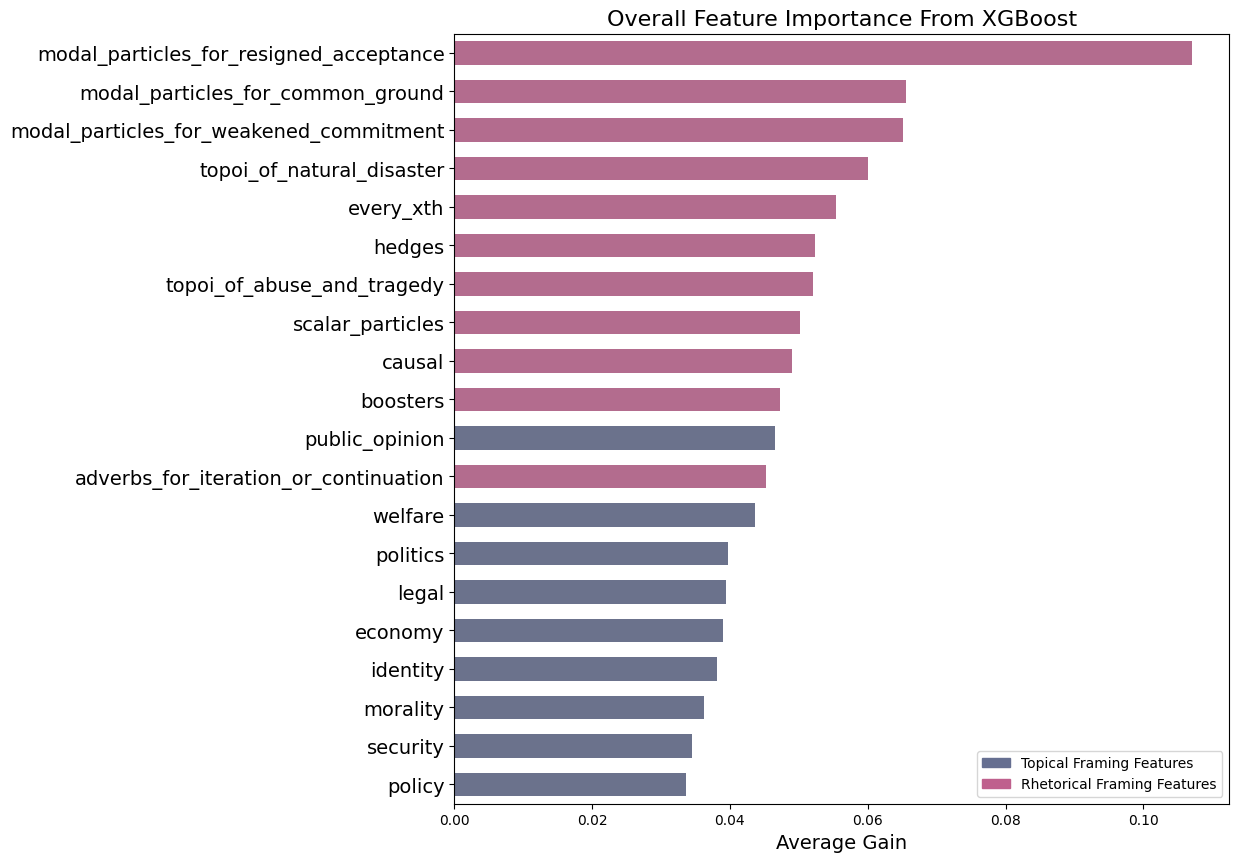

In [17]:
plot_overall_feature_importance(model=MODEL, model_name=MODEL_NAME)

## 3.2 Plot per-class feature importance

In [18]:
def get_per_class_permutation_importance(model, label):
    y_pred = model.predict(X_test)
    
    importance = permutation_importance(
        xgb, 
        X_test[y_pred == label], 
        y_test[y_pred == label], 
        scoring="neg_log_loss", 
        n_repeats=N_REPEATS, 
        random_state=RANDOM_STATE
    )
    
    return importance

In [19]:
def plot_permutation_importance_distribution(importances, show_top_n, title, save_path):
    sorted_importances_idx = importances.importances_mean.argsort()
    
    df_importances = pd.DataFrame(
        importances.importances[sorted_importances_idx].T,
        columns=X.columns[sorted_importances_idx],
    )
    
    top_features_idx = df_importances.mean().nlargest(show_top_n).index[::-1]
    df_importances = df_importances[top_features_idx]

    box_colors = [feature_color.get(feat, rhetorical_feature_color) for feat in df_importances.columns] #[topical_feature_color if feature in topical_features else rhetorical_feature_color for feature in df_importances.columns]

    fig, ax = plt.subplots(figsize=(13, 4))

    ax = df_importances.boxplot(vert=False, color="black", notch=True, patch_artist=True, medianprops=dict(color='Black'))
    for patch, color in zip(ax.patches, box_colors):
        patch.set_facecolor(color)  

    ax.axvline(x=0, color="k", linestyle="--")
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Increase in Cross-Entropy Loss", fontsize=12)
    ax.grid(False)
    #ax.set_yticklabels([textwrap.fill(label.replace("_", "_\n"), width=25) for label in df_importances.columns], fontsize=12)
    ax.set_yticklabels([label for label in df_importances.columns], fontsize=12)
    
    plt.legend(
        handles=[
            mpatches.Patch(color=topical_feature_color, label='Topical Framing Features'),
            mpatches.Patch(color=rhetorical_feature_color, label='Rhetorical Framing Features')
        ],
        bbox_to_anchor=(1.05, 1), 
        loc='best',
        fontsize=12
    )
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

In [20]:
def plot_permutation_importances(importances, show_top_n, title, save_path):
    df = pd.DataFrame({'feature_name': X.columns, 'feature_importance': importances.importances_mean}).sort_values(by='feature_importance', ascending=False).iloc[0:show_top_n, ]
    
    plt.figure(figsize=(6, 3))
    sns.barplot(
        data=df, 
        x='feature_importance', 
        y='feature_name', 
        palette=[feature_color.get(feat, rhetorical_feature_color) for feat in df['feature_name']],
        width=0.6
    )
    
    plt.legend(
        handles=[
            mpatches.Patch(color=topical_feature_color, label='Topical Framing Features'),
            mpatches.Patch(color=rhetorical_feature_color, label='Rhetorical Framing Features')
        ],
        bbox_to_anchor=(1.05, 1), loc='best',
        fontsize=12
    )

    plt.xlabel("Increase in Cross-Entropy Loss", fontsize=12)
    plt.ylabel("")
    plt.title(title, fontsize=14)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

In [21]:
N_REPEATS = 100
SHOW_TOP_N = 10

In [22]:
importance_bild = get_per_class_permutation_importance(model=MODEL, label=0)
importance_faz = get_per_class_permutation_importance(model=MODEL, label=1)
importance_sz = get_per_class_permutation_importance(model=MODEL, label=2)

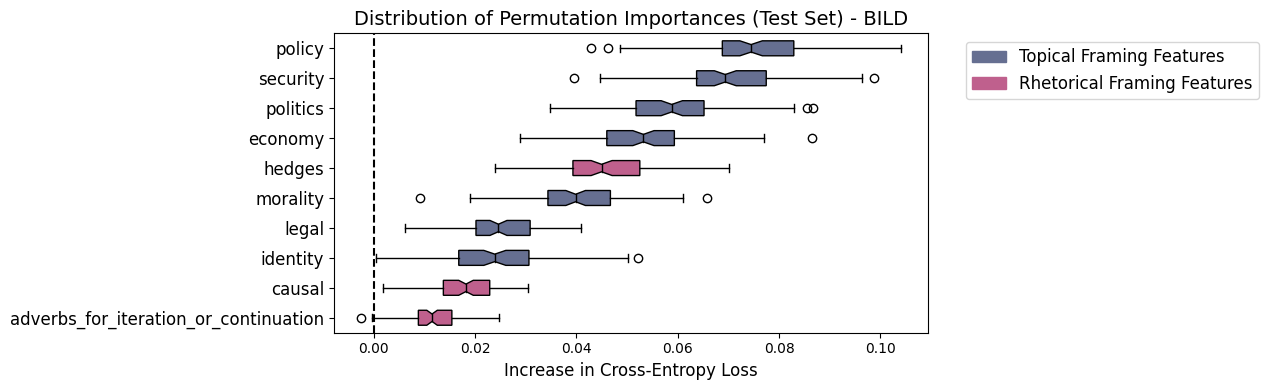

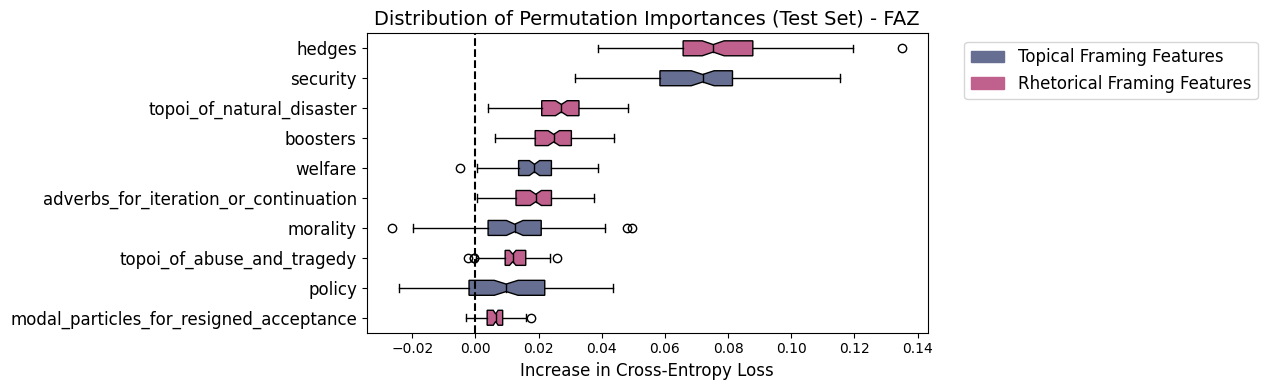

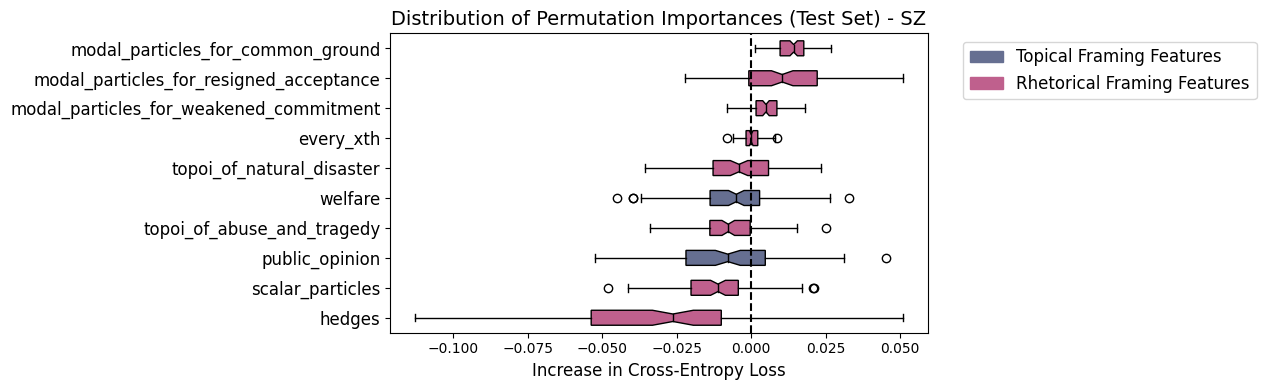

In [23]:
for importance, title in zip([importance_bild, importance_faz, importance_sz], ["BILD", "FAZ", "SZ"]):
    plot_permutation_importance_distribution(
        importances=importance,
        show_top_n=SHOW_TOP_N, 
        title="Distribution of Permutation Importances (Test Set) - {}".format(title),
        save_path="./plots/permutation_importance_distribution_{}.pdf".format(title)
    )

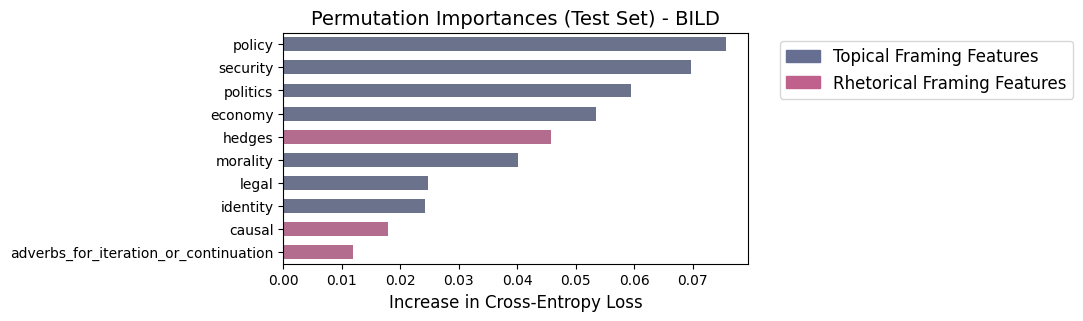

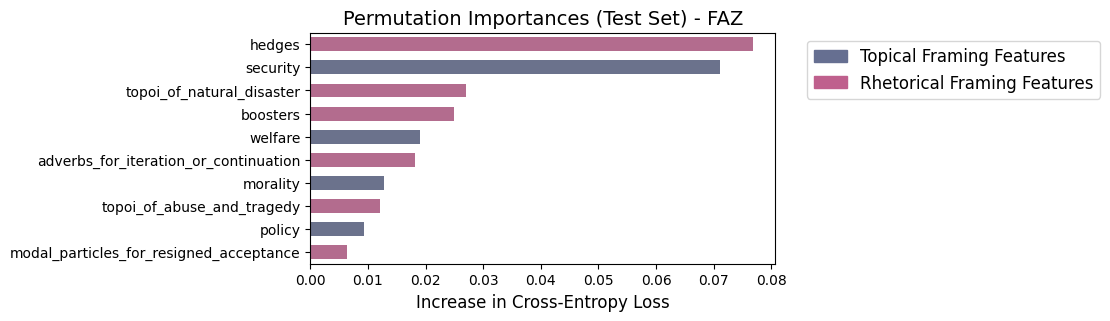

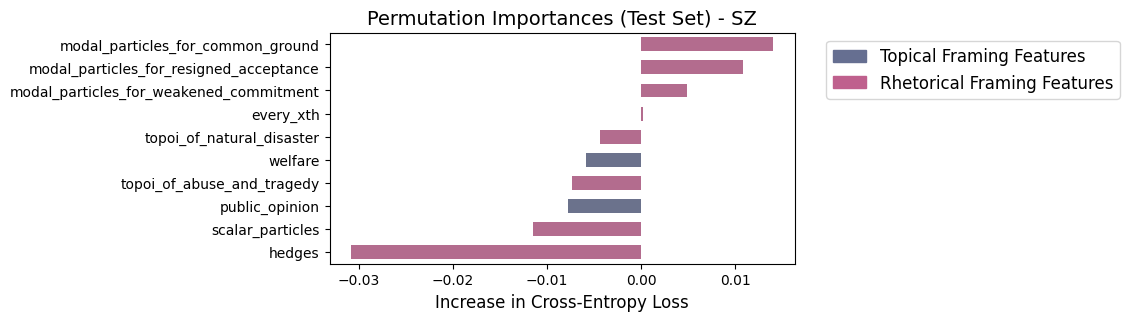

In [24]:
for importance, title in zip([importance_bild, importance_faz, importance_sz], ["BILD", "FAZ", "SZ"]):
    plot_permutation_importances(
        importances=importance,
        show_top_n=SHOW_TOP_N, 
        title="Permutation Importances (Test Set) - {}".format(title),
        save_path="./plots/permutation_importance_{}.pdf".format(title)
    )